In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
import shap

import matplotlib.pyplot as plt



In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tweets.csv',sep=';')
train,test = train_test_split(data[:1300], train_size=0.8, test_size=0.2,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(data['text'].iloc[:1020], data['sentiment'].iloc[:1020], train_size=0.8, test_size=0.2, random_state=0, stratify=data['sentiment'].iloc[:1020])

In [ ]:
tweets = train['text']

count = CountVectorizer()
bag = count.fit_transform(tweets)

count.vocabulary_

In [ ]:
tfidf = TfidfVectorizer(use_idf=True,
                         norm='l2',
                         smooth_idf=True)

np.set_printoptions(precision=2)

# Feed the tf-idf transformer with our previously created Bag of Words
tfidf.fit_transform(bag).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
vocab = Counter()
for twit in train.text:
    for word in twit.split(' '):
        vocab[word] += 1

vocab.most_common(20)

[('the', 427),
 ('RT', 403),
 ('to', 357),
 ('of', 245),
 ('', 243),
 ('#stocks', 242),
 ('a', 238),
 ('in', 231),
 ('for', 197),
 ('and', 195),
 ('on', 188),
 ('is', 168),
 ('-', 137),
 ('$SPX', 131),
 ('at', 98),
 ('$AAPL', 90),
 ('this', 86),
 ('$AMZN', 86),
 ('$SPY', 84),
 ('be', 78)]

In [ ]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

In [ ]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop = stopwords.words('english')

vocab_reduced = Counter()
for w, c in vocab.items():
    if not w in stop:
        vocab_reduced[w]=c

vocab_reduced.most_common(20)

[('RT', 403),
 ('', 243),
 ('#stocks', 242),
 ('-', 137),
 ('$SPX', 131),
 ('$AAPL', 90),
 ('$AMZN', 86),
 ('$SPY', 84),
 ('$FB', 71),
 ('I', 69),
 ('&amp;', 64),
 ('The', 56),
 ('#investing', 55),
 ('#trading', 52),
 ('$TSLA', 50),
 ('#StockMarket', 42),
 ('$QQQ', 41),
 ('$MSFT', 39),
 ('stocks', 35),
 ('#stockmarket', 31)]

In [ ]:
import re

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))

    return text


In [ ]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]


In [ ]:
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(X_train).toarray()  # sparse also works but Explanation slicing is not yet supported
X_test = vectorizer.transform(X_test).toarray()

model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1 ,solver='lbfgs',
                            multi_class='multinomial')
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        55
     neutral       0.61      0.49      0.55        67
    positive       0.49      0.89      0.63        82

    accuracy                           0.52       204
   macro avg       0.37      0.46      0.39       204
weighted avg       0.40      0.52      0.43       204



In [ ]:
clf = model.best_estimator_
print('Accuracy in test: %.3f' % clf.score(X_test, y_test))

Accuracy in test: 0.588


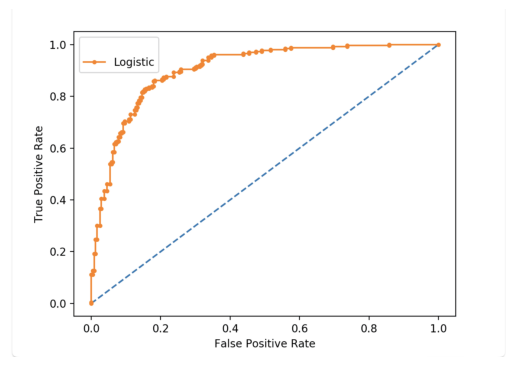

In [ ]:
from sklearn.metrics import roc_curve

# predict probabilities for CNB, MNB, BNB models:
pred_proba = model.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_proba[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# auc scores
from sklearn.metrics import roc_auc_score
auc_log = roc_auc_score(y_test, pred_proba[:,1])

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
explainer = shap.LinearExplainer(model, X_train, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_test)

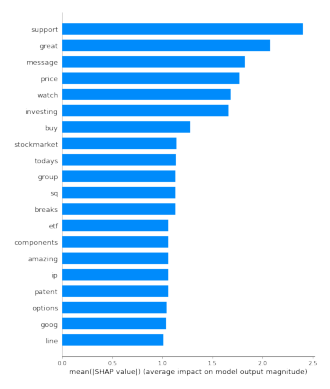

In [ ]:
shap.summary_plot(shap_values[19],
                  X_test,
                  feature_names=vectorizer.get_feature_names_out())

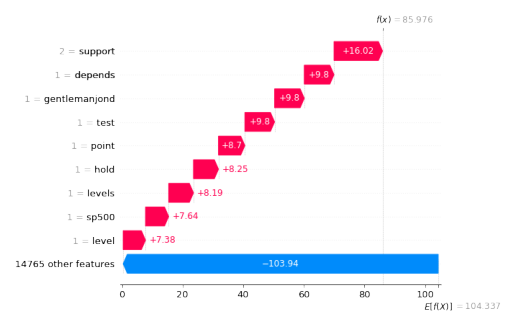

In [ ]:
shap.plots.waterfall(shap_values[6])